In [120]:
!pip install polaris-lib

In [121]:
!pip install imbalanced-learn

In [122]:
!polaris login

2024-06-20 21:34:32.509 | INFO     | polaris.hub.client:login:285 - You are already logged in to the Polaris Hub as yakavetsiv (i.yakavets@gmail.com). Set `overwrite=True` to force re-authentication.


In [123]:
# @title Set an owner
owner = 'qumark' # @param {type:"string"}
print(f"You have set \"{owner}\" as the owner")

You have set "qumark" as the owner


In [124]:
from functools import partial

import polaris as po
import datamol as dm
import numpy as np

In [125]:
benchmark = po.load_benchmark("polaris/pkis1-kit-wt-mut-c-1")
train, test = benchmark.get_train_test_split(featurization_fn=partial(dm.to_fp, fp_type='ecfp'))
#train, test = benchmark.get_train_test_split()
train[0]

2024-06-20 21:34:35.122 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-20 21:34:35.126 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 {'CLASS_KIT_(T6701_mutant)': 0.0,
  'CLASS_KIT_(V560G_mutant)': 0.0,
  'CLASS_KIT': 0.0})

In [126]:
dm.list_supported_fingerprints()

{'maccs': <function rdkit.Chem.rdMolDescriptors.GetMACCSKeysFingerprint>,
 'pattern': <function rdkit.Chem.rdmolops.PatternFingerprint>,
 'layered': <function rdkit.Chem.rdmolops.LayeredFingerprint>,
 'erg': <function rdkit.Chem.rdReducedGraphs.GetErGFingerprint>,
 'estate': <function datamol.fp.<lambda>(x, **args)>,
 'avalon-count': <function rdkit.Avalon.pyAvalonTools.GetAvalonCountFP>,
 'ecfp': <function rdkit.Chem.rdFingerprintGenerator.GetMorganGenerator>,
 'fcfp': <function rdkit.Chem.rdFingerprintGenerator.GetMorganGenerator>,
 'topological': <function rdkit.Chem.rdFingerprintGenerator.GetTopologicalTorsionGenerator>,
 'atompair': <function rdkit.Chem.rdFingerprintGenerator.GetAtomPairGenerator>,
 'rdkit': <function rdkit.Chem.rdFingerprintGenerator.GetRDKitFPGenerator>,
 'ecfp-count': <function rdkit.Chem.rdFingerprintGenerator.GetMorganGenerator>,
 'fcfp-count': <function rdkit.Chem.rdFingerprintGenerator.GetMorganGenerator>,
 'topological-count': <function rdkit.Chem.rdFinger

In [127]:
#smiles = [t[0] for t in train]
#print(smiles)

In [128]:
target_order = ['CLASS_KIT', 'CLASS_KIT_(T6701_mutant)', 'CLASS_KIT_(V560G_mutant)']

ys = train.y
ys = np.stack([ys[target] for target in target_order], axis=1)
ys.shape

(277, 3)

In [134]:
## Balancing multi-task

from functools import partial

from imblearn.over_sampling import SMOTE
import polaris as po
import datamol as dm
import numpy as np

mapping = {
 (0.0, 0.0, 0.0): 0,
 (1.0, 0.0, 0.0): 1,
 (1.0, 0.0, 1.0): 2,
 (1.0, 1.0, 0.0): 3,
 (1.0, 1.0, 1.0): 4,
}
inv_mapping = {v: k for k, v in mapping.items()}

# load dataset
benchmark = po.load_benchmark("polaris/pkis1-kit-wt-mut-c-1")
# use ECFP fingerprint
train, test = benchmark.get_train_test_split(featurization_fn=partial(dm.to_fp, fp_type='ecfp'))

# define order of target values
target_order = ['CLASS_KIT', 'CLASS_KIT_(T6701_mutant)', 'CLASS_KIT_(V560G_mutant)']

# reshape the y values for convenience
ys = train.y
ys = np.stack([ys[target] for target in target_order], axis=1)
ys.shape

# remove the rows with NaN values
mask = ~np.any(np.isnan(ys), axis=1)
mask.sum()
X = train.X[mask]
ys = ys[mask]

ys_scalarized = [tuple(item) for item in ys]
ys_scalarized = [mapping[item] for i, item in enumerate(ys_scalarized)]

X_resampled, y_resampled = SMOTE(k_neighbors=2).fit_resample(X, ys_scalarized)
y_resampled = [inv_mapping[item] for i, item in enumerate(y_resampled)]

2024-06-20 21:36:46.761 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-20 21:36:46.765 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


Text(0.5, 1.0, 'CLASS_KIT')

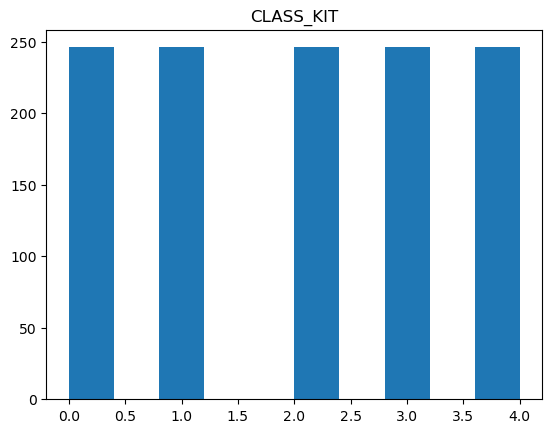

In [136]:
plt.hist(y_resampled)
plt.title(target_order[0])

In [137]:
## Balancing individual tasks

from functools import partial

from imblearn.over_sampling import SMOTE
import polaris as po
import datamol as dm
import numpy as np

# load dataset
benchmark = po.load_benchmark("polaris/pkis1-kit-wt-mut-c-1")
# use ECFP fingerprint
train, test = benchmark.get_train_test_split(featurization_fn=partial(dm.to_fp, fp_type='ecfp'))

# define order of target values
target_order = ['CLASS_KIT', 'CLASS_KIT_(T6701_mutant)', 'CLASS_KIT_(V560G_mutant)']

# reshape the y values for convenience
ys = train.y
ys = np.stack([ys[target] for target in target_order], axis=1)
ys.shape

# remove the rows with NaN values
mask = ~np.any(np.isnan(ys), axis=1)
mask.sum()
X = train.X[mask]
ys = ys[mask]

X_KIT_resampled, y_KIT_resampled = SMOTE().fit_resample(X, ys[:, 0])
X_T670I_resampled, y_T670I_resampled = SMOTE().fit_resample(X, ys[:, 1])
X_V560G_resampled, y_V560G_resampled = SMOTE().fit_resample(X, ys[:, 2])

2024-06-20 21:39:21.732 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-20 21:39:21.737 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


In [98]:
y_tuples = [tuple(y.tolist()) for y in ys]
set(y_tuples)

{(0.0, 0.0, 0.0),
 (1.0, 0.0, 0.0),
 (1.0, 0.0, 1.0),
 (1.0, 1.0, 0.0),
 (1.0, 1.0, 1.0)}

## Checking dataset imbalance

In [47]:
import matplotlib.pyplot as plt

There is only 30 binders.


Text(0.5, 1.0, 'CLASS_KIT')

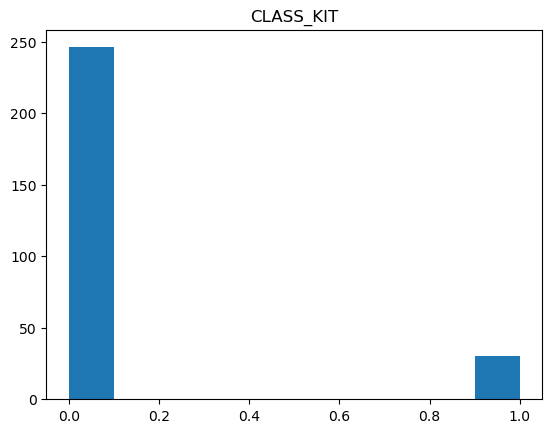

In [48]:
plt.hist(ys[:, 0])
num_binders = list(ys[:, 0] == 1.0).count(True)
print(f"There is only {num_binders} binders.")
plt.title(target_order[0])

There is only 7 binders.


Text(0.5, 1.0, 'CLASS_KIT_(T6701_mutant)')

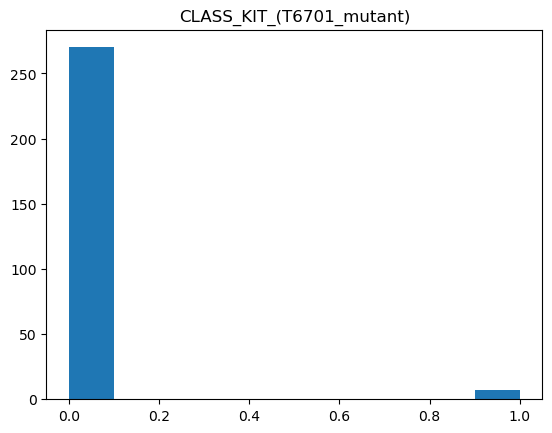

In [49]:
num_binders = list(ys[:, 1] == 1.0).count(True)
print(f"There is only {num_binders} binders.")
plt.hist(ys[:, 1])
plt.title(target_order[1])

In [117]:
1.0 - 30/len(ys[:, 1])

0.8913043478260869

There is only 8 binders.


Text(0.5, 1.0, 'CLASS_KIT_(V560G_mutant)')

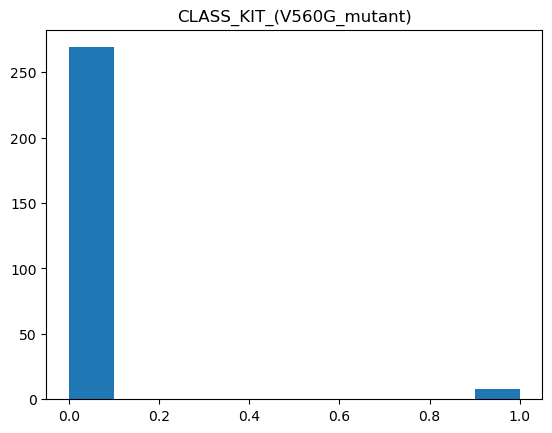

In [50]:
plt.hist(ys[:, 2])
num_binders = list(ys[:, 2] == 1.0).count(True)
print(f"There is only {num_binders} binders.")
plt.title(target_order[2])

## Addressing imbalance

In [51]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from numpy import where

276

In [53]:
mask = ~np.any(np.isnan(ys), axis=1)
mask.sum()

X = train.X[mask]
ys = ys[mask]

In [54]:
print(X.shape)
print(ys.shape)

(276, 2048)
(276, 3)


In [55]:
X_resampled, y_resampled = SMOTE().fit_resample(X, ys[:, 0])

In [56]:
print(sorted(Counter(y_resampled).items()))

[(0.0, 246), (1.0, 246)]


TypeError: 'bool' object is not iterable

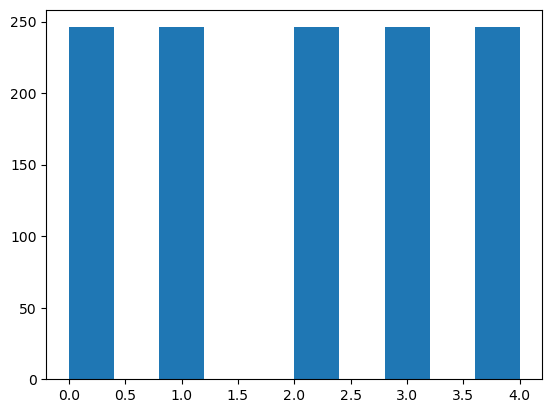

In [118]:
plt.hist(y_resampled)
num_binders = list(y_resampled == 1.0).count(True)
print(f"There is only {num_binders} binders.")
plt.title(target_order[0])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [15]:
# summarize class distribution
counter = Counter(ys[:, 0])
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = where(ys[:, 0] == label)[0]
 plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

Counter({0.0: 246, 1.0: 30, nan: 1})


NameError: name 'X' is not defined

In [69]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
resampled_principal_components = pca.fit_transform(X_resampled)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

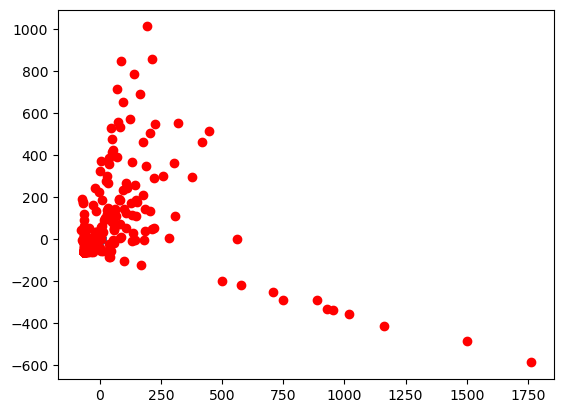

In [73]:
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.scatter(resampled_principal_components[:, 0], resampled_principal_components[:, 1], color="red")
plt.show()

In [21]:
X_list = [list(x) for x in train.X]

In [22]:
len(X_list)

277

In [120]:
len(X_list[0])

2048